In [11]:
import pandas as pd
from PIL import Image
import io
import json
import matplotlib.pyplot as plt
import re
import tensorflow as tf

In [12]:
parquet_file = [
    'data/train-00000-of-00004-b4aaeceff1d90ecb.parquet',
    'data/train-00001-of-00004-7dbbe248962764c5.parquet',
    'data/train-00002-of-00004-688fe1305a55e5cc.parquet',
    'data/train-00003-of-00004-2d0cd200555ed7fd.parquet',
    'data/validation-00000-of-00001-cc3c5779fe22e8ca.parquet',
    # 'data/test-00000-of-00001-9c204eb3f4e11791.parquet',
    ]

df = pd.concat([pd.read_parquet(f) for f in parquet_file])
df.head()

,image,ground_truth
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""Nasi Campur Bal..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""SPGTHY BOLOGNAS..."
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""HAKAU UDANG"", ""..."
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""Bintang Bremer""..."
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": {""nm"": ""BASO BIHUN"", ""un..."


In [13]:
json.loads(df['ground_truth'].iloc[4])['valid_line']

[{'words': [{'quad': {'x2': 172,
     'y3': 836,
     'x3': 172,
     'y4': 836,
     'x1': 96,
     'y1': 800,
     'x4': 96,
     'y2': 800},
    'is_key': 0,
    'row_id': 2119099,
    'text': 'BASO'},
   {'quad': {'x2': 272,
     'y3': 834,
     'x3': 272,
     'y4': 834,
     'x1': 180,
     'y1': 798,
     'x4': 180,
     'y2': 798},
    'is_key': 0,
    'row_id': 2119099,
    'text': 'BIHUN'}],
  'category': 'menu.nm',
  'group_id': 3,
  'sub_group_id': 0},
 {'words': [{'quad': {'x2': 444,
     'y3': 830,
     'x3': 444,
     'y4': 830,
     'x1': 424,
     'y1': 796,
     'x4': 424,
     'y2': 796},
    'is_key': 0,
    'row_id': 2119099,
    'text': '1'}],
  'category': 'menu.cnt',
  'group_id': 3,
  'sub_group_id': 0},
 {'words': [{'quad': {'x2': 558,
     'y3': 830,
     'x3': 558,
     'y4': 830,
     'x1': 454,
     'y1': 794,
     'x4': 454,
     'y2': 794},
    'is_key': 0,
    'row_id': 2119099,
    'text': '43.636'}],
  'category': 'menu.unitprice',
  'group_id': 3,
  

In [14]:
determined_labels = {'total_text': 0, 'total_value': 1, 'tax_text': 2, 'tax_value': 3, 'other': 4}

In [15]:
# Fungsi transformasi
def transform_json(data):
    result = []
    for item in data:
        category = item.get("category", "").lower()
        for word in item.get("words", []):
            quad = word.get("quad", {})
            is_key = word.get("is_key", 0)
            text = word.get("text", "")
        
            
            # Penentuan label
            if category == "total.total_price":
                label = "total_text" if is_key == 1 else "total_value"
            elif category == "sub_total.tax_price":
                label = "tax_text" if is_key == 1 else "tax_value"
            else:
                label = "other"
            
            # Menambahkan hasil transformasi ke list hasil
            result.append({
                "quad": quad,
                "text": text,
                "label": label
            })
    return result

In [16]:
# Fungsi untuk proses seluruh kolom
def process_dataframe(row):
    # Parsing data JSON dari kolom
    valid_line = json.loads(row)['valid_line']

    # Ambil size gambar
    meta = json.loads(row).get('meta', {})
    image_size = meta.get('image_size', None)

    # Transformasi data menggunakan fungsi sebelumnya
    transformed_data = transform_json(valid_line)

    # Mengembalikan hasil transformasi dan image_size
    return image_size, transformed_data
# Menerapkan ke seluruh DataFrame
df['transformed'] = df['ground_truth'].apply(process_dataframe)

In [17]:
df['transformed']

0     ({'width': 864, 'height': 1296}, [{'quad': {'x...
1     ({'width': 864, 'height': 1296}, [{'quad': {'x...
2     ({'width': 720, 'height': 1280}, [{'quad': {'x...
3     ({'width': 1108, 'height': 1478}, [{'quad': {'...
4     ({'width': 864, 'height': 1296}, [{'quad': {'x...
                            ...                        
95    ({'width': 720, 'height': 1280}, [{'quad': {'x...
96    ({'width': 864, 'height': 1296}, [{'quad': {'x...
97    ({'width': 864, 'height': 1296}, [{'quad': {'x...
98    ({'width': 576, 'height': 864}, [{'quad': {'x2...
99    ({'width': 864, 'height': 1296}, [{'quad': {'x...
Name: transformed, Length: 900, dtype: object

In [18]:
df['transformed'].iloc[4]

({'width': 864, 'height': 1296},
 [{'quad': {'x2': 172,
    'y3': 836,
    'x3': 172,
    'y4': 836,
    'x1': 96,
    'y1': 800,
    'x4': 96,
    'y2': 800},
   'text': 'BASO',
   'label': 'other'},
  {'quad': {'x2': 272,
    'y3': 834,
    'x3': 272,
    'y4': 834,
    'x1': 180,
    'y1': 798,
    'x4': 180,
    'y2': 798},
   'text': 'BIHUN',
   'label': 'other'},
  {'quad': {'x2': 444,
    'y3': 830,
    'x3': 444,
    'y4': 830,
    'x1': 424,
    'y1': 796,
    'x4': 424,
    'y2': 796},
   'text': '1',
   'label': 'other'},
  {'quad': {'x2': 558,
    'y3': 830,
    'x3': 558,
    'y4': 830,
    'x1': 454,
    'y1': 794,
    'x4': 454,
    'y2': 794},
   'text': '43.636',
   'label': 'other'},
  {'quad': {'x2': 734,
    'y3': 830,
    'x3': 734,
    'y4': 830,
    'x1': 630,
    'y1': 794,
    'x4': 630,
    'y2': 794},
   'text': '43.636',
   'label': 'other'},
  {'quad': {'x2': 184,
    'y3': 886,
    'x3': 184,
    'y4': 886,
    'x1': 94,
    'y1': 850,
    'x4': 94,
    'y

In [19]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

In [20]:
# Parameter
MAX_CHAR_VOCAB = 100
# MAX_CHAR_SEQUENCE_LENGTH = 50

In [21]:
# Ekstraksi fitur untuk tahap 1
def extract_features_and_labels_stage1(transformed_data):
    features, texts, labels = [], [], []
    for row in transformed_data:
        image_size, boxs = row
        for item in boxs:
            quad = item["quad"]
            feature = [
                quad["x1"] / image_size['width'], quad["y1"] / image_size['height'], 
                quad["x2"] / image_size['width'], quad["y2"] / image_size['height'], 
                quad["x3"] / image_size['width'], quad["y3"] / image_size['height'], 
                quad["x4"] / image_size['width'], quad["y4"] / image_size['height']
            ]
            features.append(feature)
            texts.append(item["text"])
            labels.append(item["label"])
            # labels.append(item["label"] if item["label"] in ["total_text", "tax_text", "other"] else "other")
    return np.array(features), texts, np.array(labels)

In [22]:
# Tokenisasi karakter
def char_tokenizer(texts):
    vocab = set("".join(texts))
    char_to_idx = {char: idx + 1 for idx, char in enumerate(vocab)}
    sequences = [[char_to_idx[char] for char in text] for text in texts]
    return sequences, char_to_idx

In [23]:
# Ekstraksi data dan fitur tahap 1
features_stage1, texts_stage1, labels_stage1 = extract_features_and_labels_stage1(df["transformed"])
char_sequences_stage1, char_to_idx = char_tokenizer(texts_stage1)
char_padded_stage1 = pad_sequences(char_sequences_stage1, maxlen=50)
label_encoder_stage1 = LabelEncoder()
encoded_labels_stage1 = label_encoder_stage1.fit_transform(labels_stage1)

# Split data tahap 1
X_train_features_1, X_test_features_1, X_train_chars_1, X_test_chars_1, y_train_1, y_test_1 = train_test_split(
    features_stage1, char_padded_stage1, encoded_labels_stage1, test_size=0.2, random_state=42
)

# Model tahap 1
geo_input_1 = tf.keras.Input(shape=(features_stage1.shape[1],))
char_input_1 = tf.keras.Input(shape=(50,))
geo_dense_1 = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.001))(geo_input_1)
geo_dense_1 = tf.keras.layers.BatchNormalization()(geo_dense_1)
char_embed_1 = tf.keras.layers.Embedding(input_dim=len(char_to_idx) + 1, output_dim=64)(char_input_1)
char_lstm_1 = tf.keras.layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3)(char_embed_1)
combined_1 = tf.keras.layers.concatenate([geo_dense_1, char_lstm_1])
combined_dense_1 = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=l2(0.001))(combined_1)
output_1 = tf.keras.layers.Dense(len(label_encoder_stage1.classes_), activation="softmax")(combined_dense_1)

model_stage1 = tf.keras.Model(inputs=[geo_input_1, char_input_1], outputs=output_1)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_stage1.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callback = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train model tahap 1
history_stage1 = model_stage1.fit(
    [X_train_features_1, X_train_chars_1], y_train_1,
    validation_split=0.2, epochs=50, batch_size=32, callbacks=[callback]
)

# Evaluasi model tahap 1
loss_1, accuracy_1 = model_stage1.evaluate([X_test_features_1, X_test_chars_1], y_test_1)
print(f"Stage 1 - Test Loss: {loss_1:.4f}")
print(f"Stage 1 - Test Accuracy: {accuracy_1:.4f}")

Epoch 1/50


c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


432/432 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.8467 - loss: 0.6332 - val_accuracy: 0.8840 - val_loss: 0.4010
Epoch 2/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8948 - loss: 0.3589 - val_accuracy: 0.9061 - val_loss: 0.3112
Epoch 3/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9076 - loss: 0.3013 - val_accuracy: 0.9124 - val_loss: 0.2801
Epoch 4/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9094 - loss: 0.2798 - val_accuracy: 0.9145 - val_loss: 0.2817
Epoch 5/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9116 - loss: 0.2648 - val_accuracy: 0.9194 - val_loss: 0.2515
Epoch 6/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9191 - loss: 0.2461 - val_accuracy: 0.9139 - val_loss: 0.2600
Epoch 7/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9189 - loss: 0.2453 - val_accuracy: 0.9307 - val_loss: 0.2304
Epoch 8/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9187 - loss: 0.2355 - val_accuracy

In [24]:
len(features_stage1)

21553

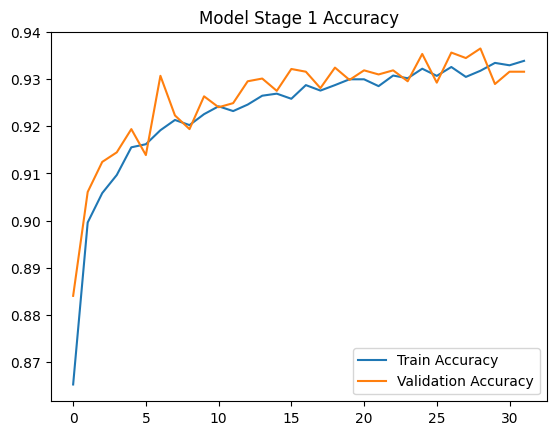

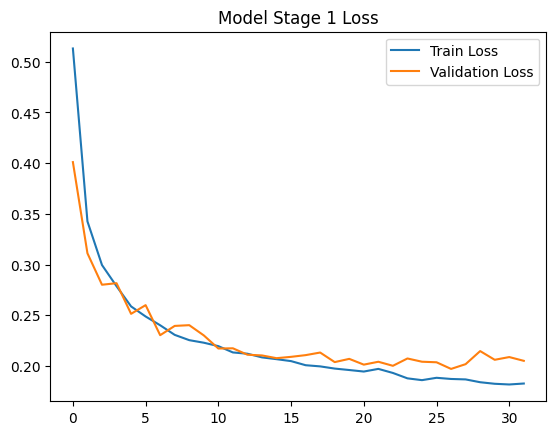

In [25]:
import matplotlib.pyplot as plt

# Stage 1
plt.plot(history_stage1.history['accuracy'], label='Train Accuracy')
plt.plot(history_stage1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Stage 1 Accuracy')
plt.legend()
plt.show()
# Stage 1
plt.plot(history_stage1.history['loss'], label='Train Loss')
plt.plot(history_stage1.history['val_loss'], label='Validation Loss')
plt.title('Model Stage 1 Loss')
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Prediksi probabilitas untuk model tahap 1
y_pred_prob_stage1 = model_stage1.predict([X_test_features_1, X_test_chars_1])

# Prediksi kelas
y_pred_stage1 = np.argmax(y_pred_prob_stage1, axis=1)

# Classification Report untuk model tahap 1
print("Classification Report - Model Stage 1:\n", classification_report(
    y_test_1, y_pred_stage1, target_names=label_encoder_stage1.classes_))

# Confusion Matrix untuk model tahap 1
conf_matrix_stage1 = confusion_matrix(y_test_1, y_pred_stage1)
print("Confusion Matrix - Model Stage 1:\n", conf_matrix_stage1)

# Evaluasi metrik
accuracy_stage1 = accuracy_score(y_test_1, y_pred_stage1)
precision_stage1 = precision_score(y_test_1, y_pred_stage1, average='weighted')
recall_stage1 = recall_score(y_test_1, y_pred_stage1, average='weighted')
f1_stage1 = f1_score(y_test_1, y_pred_stage1, average='weighted')

# Menampilkan hasil evaluasi
print(f"Stage 1 - Accuracy: {accuracy_stage1:.4f}")
print(f"Stage 1 - Precision: {precision_stage1:.4f}")
print(f"Stage 1 - Recall: {recall_stage1:.4f}")
print(f"Stage 1 - F1 Score: {f1_stage1:.4f}")

135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Classification Report - Model Stage 1:
               precision    recall  f1-score   support

       other       0.94      0.97      0.96      3681
    tax_text       0.91      0.91      0.91       138
   tax_value       0.76      0.58      0.66        95
  total_text       0.81      0.83      0.82       198
 total_value       0.66      0.31      0.42       199

    accuracy                           0.93      4311
   macro avg       0.82      0.72      0.75      4311
weighted avg       0.92      0.93      0.92      4311

Confusion Matrix - Model Stage 1:
 [[3587   12   17   37   28]
 [  11  126    0    1    0]
 [  37    0   55    0    3]
 [  33    1    0  164    0]
 [ 138    0    0    0   61]]
Stage 1 - Accuracy: 0.9262
Stage 1 - Precision: 0.9185
Stage 1 - Recall: 0.9262
Stage 1 - F1 Score: 0.9188


In [27]:
# Fungsi menghitung posisi relatif
def calculate_relative_position(item, reference_item):
    dx = (item["quad"]["x1"] + item["quad"]["x3"]) / 2 - (reference_item["quad"]["x1"] + reference_item["quad"]["x3"]) / 2
    dy = (item["quad"]["y1"] + item["quad"]["y3"]) / 2 - (reference_item["quad"]["y1"] + reference_item["quad"]["y3"]) / 2
    return [dx, dy]

In [28]:
def extract_features_and_labels_stage2(transformed_data, predictions_stage1):
    features, texts, labels = [], [], []
    prediction_index1 = 0
    prediction_index2 = 0

    for row in transformed_data:
        image_size, boxs = row
        reference_positions = {"total_text": None, "tax_text": None}
        for item in boxs:
            if predictions_stage1[prediction_index1] == "total_text":
                reference_positions["total_text"] = item
            elif predictions_stage1[prediction_index1] == "tax_text":
                reference_positions["tax_text"] = item
            prediction_index1 += 1

        for item in boxs:
            quad = item["quad"]
            feature = [
                quad["x1"] / image_size['width'], quad["y1"] / image_size['height'], 
                quad["x2"] / image_size['width'], quad["y2"] / image_size['height'], 
                quad["x3"] / image_size['width'], quad["y3"] / image_size['height'], 
                quad["x4"] / image_size['width'], quad["y4"] / image_size['height']
            ]
            if reference_positions["total_text"]:
                feature.extend(calculate_relative_position(item, reference_positions["total_text"]))
            else:
                feature.extend([0, 0])
            if reference_positions["tax_text"]:
                feature.extend(calculate_relative_position(item, reference_positions["tax_text"]))
            else:
                feature.extend([0, 0])

            # Masukkan semua label ke dalam tahap 2
            features.append(feature)
            texts.append(item["text"])
            labels.append(item['label'])
            # if item["label"] in ["total_value", "tax_value", "total_text", "tax_text"]:
            #     labels.append(item["label"])
            # else:
            #     labels.append("other")
            prediction_index2 += 1
    return np.array(features), texts, np.array(labels)


In [29]:

# Ekstraksi data dan fitur tahap 1
features_stage1, texts_stage1, labels_stage1 = extract_features_and_labels_stage1(df["transformed"])
char_sequences_stage1, char_to_idx = char_tokenizer(texts_stage1)
char_padded_stage1 = pad_sequences(char_sequences_stage1, maxlen=50)

# Prediksi untuk Tahap 2
predictions_stage1 = np.argmax(model_stage1.predict([features_stage1, char_padded_stage1]), axis=1)
predictions_stage1_labels = label_encoder_stage1.inverse_transform(predictions_stage1)

# Pastikan test_indices cocok dengan DataFrame
df_copy = df['transformed']


# Ekstraksi data untuk Tahap 2
features_stage2, texts_stage2, labels_stage2 = extract_features_and_labels_stage2(
    df_copy, predictions_stage1_labels
)

# Encode label untuk Tahap 2
label_encoder_stage2 = LabelEncoder()
encoded_labels_stage2 = label_encoder_stage2.fit_transform(labels_stage2)

# Tokenisasi dan padding untuk teks Tahap 2
char_sequences_stage2 = [[char_to_idx[char] for char in text if char in char_to_idx] for text in texts_stage2]
char_padded_stage2 = pad_sequences(char_sequences_stage2, maxlen=50)

# Split data untuk Tahap 2
X_train_features_2, X_test_features_2, X_train_chars_2, X_test_chars_2, y_train_2, y_test_2 = train_test_split(
    features_stage2, char_padded_stage2, encoded_labels_stage2, test_size=0.2, random_state=42
)

# Model Tahap 2
geo_input_2 = tf.keras.Input(shape=(features_stage2.shape[1],))
geo_dense_2 = tf.keras.layers.Dense(64, activation="relu")(geo_input_2)

char_input_2 = tf.keras.Input(shape=(50,))
char_embed_2 = tf.keras.layers.Embedding(input_dim=len(char_to_idx) + 1, output_dim=64)(char_input_2)
char_lstm_2 = tf.keras.layers.LSTM(64)(char_embed_2)

combined_2 = tf.keras.layers.concatenate([geo_dense_2, char_lstm_2])
combined_dense_2 = tf.keras.layers.Dense(128, activation="relu")(combined_2)
output_2 = tf.keras.layers.Dense(len(label_encoder_stage2.classes_), activation="softmax")(combined_dense_2)

model_stage2 = tf.keras.Model(inputs=[geo_input_2, char_input_2], outputs=output_2)

# Kompilasi Model Tahap 2
model_stage2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Pelatihan Model Tahap 2
callback = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_stage2 = model_stage2.fit(
    [X_train_features_2, X_train_chars_2], y_train_2,
    validation_split=0.2, epochs=50, batch_size=32, callbacks=[callback]
)

# Evaluasi Model Tahap 2
loss_2, accuracy_2 = model_stage2.evaluate([X_test_features_2, X_test_chars_2], y_test_2)
print(f"Stage 2 - Test Loss: {loss_2:.4f}")
print(f"Stage 2 - Test Accuracy: {accuracy_2:.4f}")


674/674 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
Epoch 1/50


c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_9', 'keras_tensor_11']. Received: the structure of inputs=('*', '*')
  warnings.warn(


432/432 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.8020 - loss: 3.8236 - val_accuracy: 0.9078 - val_loss: 0.3576
Epoch 2/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9134 - loss: 0.3882 - val_accuracy: 0.9226 - val_loss: 0.3476
Epoch 3/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9317 - loss: 0.3461 - val_accuracy: 0.9435 - val_loss: 0.2264
Epoch 4/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9395 - loss: 0.2961 - val_accuracy: 0.9342 - val_loss: 0.2921
Epoch 5/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9514 - loss: 0.2184 - val_accuracy: 0.9423 - val_loss: 0.2123
Epoch 6/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9502 - loss: 0.2076 - val_accuracy: 0.9606 - val_loss: 0.1544
Epoch 7/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9555 - loss: 0.1702 - val_accuracy: 0.9498 - val_loss: 0.2163
Epoch 8/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9574 - loss: 0.1972 - val_accuracy: 0

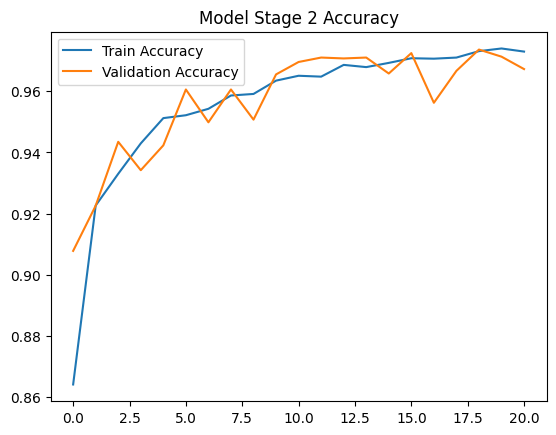

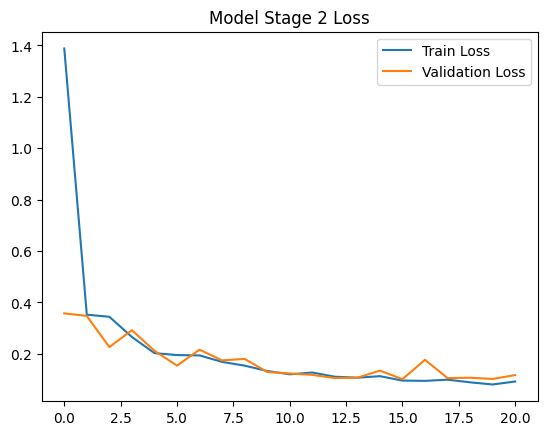

In [30]:

# Stage 2
plt.plot(history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history_stage2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Stage 2 Accuracy')
plt.legend()
plt.show()

# Stage 2
plt.plot(history_stage2.history['loss'], label='Train Loss')
plt.plot(history_stage2.history['val_loss'], label='Validation Loss')
plt.title('Model Stage 2 Loss')
plt.legend()
plt.show()


In [31]:
# Prediksi probabilitas untuk model tahap 2
y_pred_prob_stage2 = model_stage2.predict([X_test_features_2, X_test_chars_2])

# Prediksi kelas
y_pred_stage2 = np.argmax(y_pred_prob_stage2, axis=1)

# Classification Report untuk model tahap 2
print("Classification Report - Model Stage 2:\n", classification_report(
    y_test_2, y_pred_stage2, target_names=label_encoder_stage2.classes_))

# Confusion Matrix untuk model tahap 2
conf_matrix_stage2 = confusion_matrix(y_test_2, y_pred_stage2)
print("Confusion Matrix - Model Stage 2:\n", conf_matrix_stage2)

# Evaluasi metrik
accuracy_stage2 = accuracy_score(y_test_2, y_pred_stage2)
precision_stage2 = precision_score(y_test_2, y_pred_stage2, average='weighted')
recall_stage2 = recall_score(y_test_2, y_pred_stage2, average='weighted')
f1_stage2 = f1_score(y_test_2, y_pred_stage2, average='weighted')

# Menampilkan hasil evaluasi
print(f"Stage 2 - Accuracy: {accuracy_stage2:.4f}")
print(f"Stage 2 - Precision: {precision_stage2:.4f}")
print(f"Stage 2 - Recall: {recall_stage2:.4f}")
print(f"Stage 2 - F1 Score: {f1_stage2:.4f}")


135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Classification Report - Model Stage 2:
               precision    recall  f1-score   support

       other       0.98      0.98      0.98      3681
    tax_text       0.91      0.93      0.92       138
   tax_value       0.87      0.96      0.91        95
  total_text       0.85      0.87      0.86       198
 total_value       0.88      0.75      0.81       199

    accuracy                           0.96      4311
   macro avg       0.90      0.90      0.90      4311
weighted avg       0.96      0.96      0.96      4311

Confusion Matrix - Model Stage 2:
 [[3610   12    8   31   20]
 [   5  129    4    0    0]
 [   4    0   91    0    0]
 [  25    0    0  173    0]
 [  48    0    2    0  149]]
Stage 2 - Accuracy: 0.9631
Stage 2 - Precision: 0.9629
Stage 2 - Recall: 0.9631
Stage 2 - F1 Score: 0.9627


In [32]:
def predict_stage1_and_stage2(input_data, model_stage1, model_stage2, char_to_idx, label_encoder_stage1, label_encoder_stage2, image_size):
    # Preprocess input data
    features = []
    texts = []
    for item in input_data:
        quad = item['quad']
        feature = [
            quad["x1"] / image_size['width'], quad["y1"] / image_size['height'], 
            quad["x2"] / image_size['width'], quad["y2"] / image_size['height'], 
            quad["x3"] / image_size['width'], quad["y3"] / image_size['height'], 
            quad["x4"] / image_size['width'], quad["y4"] / image_size['height']
        ]
        features.append(feature)
        texts.append(item['text'])

    features = np.array(features)
    char_sequences = [[char_to_idx[char] for char in text if char in char_to_idx] for text in texts]
    char_padded = pad_sequences(char_sequences, maxlen=50)

    # Predict stage 1
    predictions_stage1 = np.argmax(model_stage1.predict([features, char_padded]), axis=1)
    predictions_stage1_labels = label_encoder_stage1.inverse_transform(predictions_stage1)

    # Prepare data for stage 2
    reference_positions = {"total_text": None, "tax_text": None}
    for i, item in enumerate(input_data):
        if predictions_stage1_labels[i] == "total_text":
            reference_positions["total_text"] = item
        elif predictions_stage1_labels[i] == "tax_text":
            reference_positions["tax_text"] = item

    features_stage2 = []
    for item in input_data:
        quad = item['quad']
        feature = [
            quad["x1"] / image_size['width'], quad["y1"] / image_size['height'], 
            quad["x2"] / image_size['width'], quad["y2"] / image_size['height'], 
            quad["x3"] / image_size['width'], quad["y3"] / image_size['height'], 
            quad["x4"] / image_size['width'], quad["y4"] / image_size['height']
        ]
        if reference_positions["total_text"]:
            feature.extend(calculate_relative_position(item, reference_positions["total_text"]))
        else:
            feature.extend([0, 0])
        if reference_positions["tax_text"]:
            feature.extend(calculate_relative_position(item, reference_positions["tax_text"]))
        else:
            feature.extend([0, 0])
        features_stage2.append(feature)

    features_stage2 = np.array(features_stage2)

    # Predict stage 2
    predictions_stage2 = np.argmax(model_stage2.predict([features_stage2, char_padded]), axis=1)
    predictions_stage2_labels = label_encoder_stage2.inverse_transform(predictions_stage2)

    # Combine results
    results = []
    for i, item in enumerate(input_data):
        results.append({
            "text": item["text"],
            "quad": item["quad"],
            "stage1_label": predictions_stage1_labels[i],
            "stage2_label": predictions_stage2_labels[i],
        })

    return results



# Data input tanpa label
input_data = [
  {'quad': {'x2': 172, 'y3': 836, 'x3': 172, 'y4': 836, 'x1': 96, 'y1': 800, 'x4': 96, 'y2': 800}, 'text': 'BASO'},
  {'quad': {'x2': 272, 'y3': 834, 'x3': 272, 'y4': 834, 'x1': 180, 'y1': 798, 'x4': 180, 'y2': 798}, 'text': 'BIHUN'},
  {'quad': {'x2': 444, 'y3': 830, 'x3': 444, 'y4': 830, 'x1': 424, 'y1': 796, 'x4': 424, 'y2': 796}, 'text': '1'},
  {'quad': {'x2': 558, 'y3': 830, 'x3': 558, 'y4': 830, 'x1': 454, 'y1': 794, 'x4': 454, 'y2': 794}, 'text': '43.636'},
  {'quad': {'x2': 734, 'y3': 830, 'x3': 734, 'y4': 830, 'x1': 630, 'y1': 794, 'x4': 630, 'y2': 794}, 'text': '43.636'},
  {'quad': {'x2': 184, 'y3': 886, 'x3': 184, 'y4': 886, 'x1': 94, 'y1': 850, 'x4': 94, 'y2': 850}, 'text': 'TOTAL'},
  {'quad': {'x2': 742, 'y3': 878, 'x3': 742, 'y4': 878, 'x1': 636, 'y1': 842, 'x4': 636, 'y2': 842}, 'text': '43.636'},
  {'quad': {'x2': 148, 'y3': 984, 'x3': 148, 'y4': 984, 'x1': 90, 'y1': 948, 'x4': 90, 'y2': 948}, 'text': 'TAX'},
  {'quad': {'x2': 249, 'y3': 984, 'x3': 249, 'y4': 984, 'x1': 157, 'y1': 948, 'x4': 157, 'y2': 948}, 'text': '10.00'},
  {'quad': {'x2': 284, 'y3': 982, 'x3': 284, 'y4': 982, 'x1': 258, 'y1': 946, 'x4': 258, 'y2': 946}, 'text': '%'},
  {'quad': {'x2': 747, 'y3': 976, 'x3': 747, 'y4': 976, 'x1': 655, 'y1': 940, 'x4': 655, 'y2': 940}, 'text': '4.364'},
  {'quad': {'x2': 177, 'y3': 1034, 'x3': 177, 'y4': 1034, 'x1': 83, 'y1': 998, 'x4': 83, 'y2': 998}, 'text': 'GRAND'},
  {'quad': {'x2': 277, 'y3': 1034, 'x3': 277, 'y4': 1034, 'x1': 187, 'y1': 998, 'x4': 187, 'y2': 998}, 'text': 'TOTAL'},
  {'quad': {'x2': 745, 'y3': 1023, 'x3': 746, 'y4': 1027, 'x1': 637, 'y1': 989, 'x4': 638, 'y2': 986}, 'text': '48.000'},
  {'quad': {'x2': 178, 'y3': 1086, 'x3': 178, 'y4': 1086, 'x1': 86, 'y1': 1048, 'x4': 86, 'y2': 1048}, 'text': 'TUNAI'},
  {'quad': {'x2': 751, 'y3': 1071, 'x3': 752, 'y4': 1075, 'x1': 643, 'y1': 1040, 'x4': 644, 'y2': 1036}, 'text': '50.000'},
  {'quad': {'x2': 208, 'y3': 1136, 'x3': 207, 'y4': 1133, 'x1': 82, 'y1': 1096, 'x4': 81, 'y2': 1099}, 'text': 'KEMBALI'},
  {'quad': {'x2': 747, 'y3': 1121, 'x3': 748, 'y4': 1124, 'x1': 657, 'y1': 1087, 'x4': 658, 'y2': 1084}, 'text': '2.000'}
]


# Dimensi gambar
image_size = {'width': 864, 'height': 1296}

# Prediksi
predicted_results = predict_stage1_and_stage2(
    input_data=input_data,
    model_stage1=model_stage1,
    model_stage2=model_stage2,
    char_to_idx=char_to_idx,
    label_encoder_stage1=label_encoder_stage1,
    label_encoder_stage2=label_encoder_stage2,
    image_size=image_size
)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [33]:
for result in predicted_results:
    print(result)  # Memeriksa isi dictionary


{'text': 'BASO', 'quad': {'x2': 172, 'y3': 836, 'x3': 172, 'y4': 836, 'x1': 96, 'y1': 800, 'x4': 96, 'y2': 800}, 'stage1_label': np.str_('other'), 'stage2_label': np.str_('other')}
{'text': 'BIHUN', 'quad': {'x2': 272, 'y3': 834, 'x3': 272, 'y4': 834, 'x1': 180, 'y1': 798, 'x4': 180, 'y2': 798}, 'stage1_label': np.str_('other'), 'stage2_label': np.str_('other')}
{'text': '1', 'quad': {'x2': 444, 'y3': 830, 'x3': 444, 'y4': 830, 'x1': 424, 'y1': 796, 'x4': 424, 'y2': 796}, 'stage1_label': np.str_('other'), 'stage2_label': np.str_('other')}
{'text': '43.636', 'quad': {'x2': 558, 'y3': 830, 'x3': 558, 'y4': 830, 'x1': 454, 'y1': 794, 'x4': 454, 'y2': 794}, 'stage1_label': np.str_('other'), 'stage2_label': np.str_('other')}
{'text': '43.636', 'quad': {'x2': 734, 'y3': 830, 'x3': 734, 'y4': 830, 'x1': 630, 'y1': 794, 'x4': 630, 'y2': 794}, 'stage1_label': np.str_('other'), 'stage2_label': np.str_('other')}
{'text': 'TOTAL', 'quad': {'x2': 184, 'y3': 886, 'x3': 184, 'y4': 886, 'x1': 94, 'y1'

In [ ]:
def extract_decimal_number(text):
    # Hapus simbol mata uang dan karakter non-angka lainnya
    cleaned_text = re.sub(r'[^\d,.\s]', '', text)  # Menghapus simbol selain angka, koma, titik, atau spasi
    cleaned_text = re.sub(r'\s*\.\s*', '', cleaned_text)  # Menghapus titik yang muncul setelah simbol mata uang
    # Ganti koma dengan titik untuk konsistensi desimal
    normalized = cleaned_text.replace(",", ".")
    # Hilangkan pemisah ribuan (titik di tengah angka)
    cleaned_number = re.sub(r'\.(?=\d{3}($|\D))', '', normalized)
    # Konversi ke float
    try:
        return float(cleaned_number)
    except ValueError:
        return 0  # Jika angka tidak valid

In [45]:
def extract_text_values(predicted_results):
    total_value = 0
    tax_value = 0

    for result in predicted_results:
        if result['stage2_label'] == "total_value":
            total_value = extract_decimal_number(result['text'])
            # try:
            #     total_value = float(result['text'].replace(",", "").replace(".", "").replace(" ", ""))
            # except ValueError:
            #     total_value = 0  # Jika parsing gagal, atur default 0
        elif result['stage2_label'] == "tax_value":
            tax_value = extract_decimal_number(result['text'])
            # try:
            #     tax_value = float(result['text'].replace(",", "").replace(".", "").replace(" ", ""))
            # except ValueError:
            #     tax_value = 0  # Jika parsing gagal, atur default 0

    return {
        "total_value": total_value,
        "tax_value": tax_value,
    }

# Menggunakan fungsi untuk menghasilkan JSON
result_json = extract_text_values(predicted_results)

# Cetak hasil dalam format JSON
import json
print(json.dumps(result_json, indent=4))


4364
48000
{
    "total_value": 48000.0,
    "tax_value": 4364.0
}


In [36]:
# Save the model to a file
model_stage1.save("model_stage1.h5")
model_stage2.save("model_stage2.h5")

In [37]:
import pickle
# Simpan ke dalam file .pkl
with open("char_to_idx.pkl", "wb") as file:
    pickle.dump(char_to_idx, file)

# Simpan LabelEncoder ke dalam file .pkl
with open("label_encoder_stage1.pkl", "wb") as file:
    pickle.dump(label_encoder_stage1, file)

# Simpan LabelEncoder ke dalam file .pkl
with open("label_encoder_stage2.pkl", "wb") as file:
    pickle.dump(label_encoder_stage2, file)

In [4]:
import re

def extract_decimal_number(text):
    # Hapus simbol mata uang dan karakter non-angka lainnya
    cleaned_text = re.sub(r'[^\d,.\s]', '', text)  # Menghapus simbol selain angka, koma, titik, atau spasi
    cleaned_text = re.sub(r'\s*\.\s*', '', cleaned_text)  # Menghapus titik yang muncul setelah simbol mata uang
    # Ganti koma dengan titik untuk konsistensi desimal
    normalized = cleaned_text.replace(",", ".")
    # Hilangkan pemisah ribuan (titik di tengah angka)
    cleaned_number = re.sub(r'\.(?=\d{3}($|\D))', '', normalized)
    # Konversi ke float
    try:
        return float(cleaned_number)
    except ValueError:
        return 0  # Jika angka tidak valid

# Contoh penggunaan
examples = [
    "Rp200.000,00",    # 200000.00
    "€10,000",         # 10000.0
    "$100,000.-",     # 100000.50
    "Harga total adalah ¥1.250.500,25", # 1250500.25
    "£12.345,67",      # 12345.67
    "123.456.789,12 zł", # 123456789.12
    "Rp. 91,000"
]

for text in examples:
    print(f"Original: {text} -> Extracted: {extract_decimal_number(text)}")

Original: Rp200.000,00 -> Extracted: 200000.0
Original: €10,000 -> Extracted: 10000.0
Original: $100,000.- -> Extracted: 100000.0
Original: Harga total adalah ¥1.250.500,25 -> Extracted: 1250500.25
Original: £12.345,67 -> Extracted: 12345.67
Original: 123.456.789,12 zł -> Extracted: 123456789.12
Original: Rp. 91,000 -> Extracted: 91000.0
